# An Introduction to Co-Word Analysis

by James Gopsill

<hr>

Co-word analysis is the investigation of the semantic structure of a corpus of textual data through the co-occurrence of terms. By analysing the co-occurrence of terms, a network of connected terms is generated, which enables the application of algorithms developed in graph theory to uncover underlying structures (normally referred to as themes) and examine the nature of the connections behind the terms. For example, centrality measures are often used to identify the most important and influential terms within the network structure. In addition, clustering algorithms such as Louvain community partitioning are used to identify groups of highly connected terms within a network. A primary application of co-word analysis has been the identification of research themes and key terms within scientific communities ([Ding et al. 2001][1]; [Coulter et al.][2]; [Liu et al. 2014][3]).

This notebook provides a brief introduction and demmonstration of some of the techniques that are used in co-word analysis. Hopefully it will give you a good starting point as well as the confidence to try it out on your datasets. In this introduction, we will be applying co-word analysis on the keywords used by conference papers in [DESIGN 2012][4].

The analysis is broken down in 5 steps and covers:

* Importing the relevant python packages and data;
* Generating a co-word network of keywords;
* Visualising the co-word network;
* Clustering the co-word network; and,
* Identifying key terms within the network.

Before continuing, we need to import the relevant packages for our analysis.

[1]: http://www.sciencedirect.com/science/article/pii/S0306457300000510
[2]: http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-4571(1998)49:13%3C1206::AID-ASI7%3E3.0.CO;2-F/epdf
[3]: http://delivery.acm.org/10.1145/2560000/2556969/p3553-liu.pdf?ip=137.222.114.243&id=2556969&acc=ACTIVE%20SERVICE&key=BF07A2EE685417C5%2E3DCFD3605FE4B4CE%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=638504200&CFTOKEN=96987752&__acm__=1467362675_d2665f24777acc735ff8e1e8f1bc2ab6
[4]: https://www.designsociety.org/publication/30980/ds_70_proceedings_of_design_2012_the_12th_international_design_conference_dubrovnik_croatia

In [24]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Packages we need for the analysis

import networkx as nx # Network creation, drawing and analysing package
import json # for reading json data
import matplotlib.pyplot as plt # for plotting networks diagrams
import matplotlib.patches as mpatches
import community # Louvain community clusering algorithm
import collections # Counting occurrences of items within lists
import operator # for sorting dictionary objects

## Importing the data into python

The publication data has been extracted from the book of abstracts and stored within a JSON file. The following code reads this data into a list of dictionaries in python.

In [25]:
# load the data from the file
with open('DESIGN2012.json', 'r', encoding='iso-8859-15') as f:
    data = f.read()

# read json object
data = json.loads(data)
papers = data['rows']
# pretty print an example data row
print(papers[0])

{'publication_keyword': 'new product development, success criteria and factors, project management', 'publication_author': 'Achiche S., Howard T. J., McAloone T. C., Deng L., Baron L.', 'publication_title': 'THE UNDERLYING RELATIONSHIPS BETWEEN SUCCESS CRITERIA &amp; SUCCESS FACTORS IN NPD ACTIVITIES', 'publication_conf_code': 'DESIGN 2012'}


## Extracting the keywords and counting their occurrences

Now that we have the data loaded into python, we can form a list of keywords and count how many times they have been used across the papers. This code loops through all the papers and extracts the keywords from each paper. The keywords are comma separated and all letters placed in lowercase to help the matching of keywords.

This forms a list containing all the keywords used in the conference including duplicates as some papers may have used the same keywords (and this is what we're looking for). Using the collections package enables us to find all the unique keywords and the number of times they appear within the list.

Figure 1 shows the number of times the keyowrds of occurred within the DESIGN 2012 conference (ordered by number of occurrences).

Number of Keywords: 843
[('design process', 10), ('knowledge management', 7), ('design methods', 7), ('product development', 7), ('product development process', 6), ('uncertainty', 5), ('creativity', 5), ('systems engineering', 5), ('design structure matrix', 5), ('product-service systems', 5)]


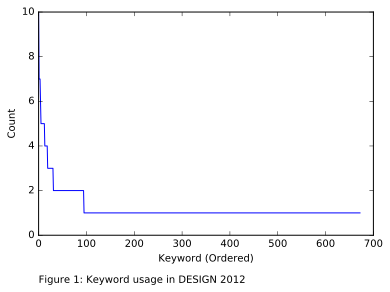

In [26]:
keyword_list = [] # empty list
for paper in papers:
    keywords = paper['publication_keyword'].lower().split(',') # splitting keywords
    keywords = [x.strip() for x in keywords] # stripping whitespace
    keyword_list.extend(keywords) # add keywords to list
    
print('Number of Keywords:', len(keyword_list))
keyword_list = collections.Counter(keyword_list).most_common() # count the number of re-occurrences of keywords
print(keyword_list[0:10])

# create list of appearence for plotting
y = [k[1] for k in keyword_list]

# plotting the number of occurrences each keyword has had
plt.plot(y)
plt.ylim(0, 10)
plt.xlabel('Keyword (Ordered)')
plt.ylabel('Count')
plt.annotate('Figure 1: Keyword usage in DESIGN 2012', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Creating the Nodes

We shall now use this keyword list to generate the nodes of the network using the NetworkX package. We also create a new list that contains the unique keywords produced by collections.Counter. In addition, the frequency relates to the number of occurrences of that keyword.

In [27]:

# Generate Graph
g = nx.Graph()

# Get the keywords of interest
graph_keywords = []
for i, keyword in enumerate(keyword_list):
    graph_keywords.append(keyword[0])
    g.add_node(i,
               keyword=keyword[0],
               freq=keyword[1]
              )

print('Number of Nodes in Network:', g.number_of_nodes())
        

Number of Nodes in Network: 673


## Creating the Edges (Co-occurrence of words)

No we have a network of nodes that are not connected. This stage takes each paper and links to keywords from that paper together. The loop also checks if an edge is present between the two nodes. If there is a connection then the weighting of that edge is increased by one. If not, a new edge is created linking the two keywords.

In [28]:
# for each paper in the conference
for paper in papers:
    # get the list of keywords from the paper
    keywords = paper['publication_keyword'].lower().split(',')
    keywords = [x.strip() for x in keywords]
    
    # loop through the keywords
    for i in range(0, len(keywords)-1):
        for j in range(i+1, len(keywords)):
            # get the indexes of the keywords so we can find them in the network
            keyword_one_idx = graph_keywords.index(keywords[i])
            keyword_two_idx = graph_keywords.index(keywords[j])
            
            # Check if the network has an edge.
            if g.has_edge(keyword_one_idx, keyword_two_idx):
                g[keyword_one_idx][keyword_two_idx]['weight'] = g[keyword_one_idx][keyword_two_idx]['weight'] + 1
            else:
                g.add_edge(keyword_one_idx, keyword_two_idx, weight=1)

print('Number of Edges in Network:', g.number_of_edges())

Number of Edges in Network: 1399


## Initial Network

The code below plots the initial network that has been created (Figure 2). It can be seen that there are a number of connected nodes that lie outside the main network structure (known as components). These are keywords that have been used by very few papers and thus, do not really tell us about the key themes within the conference. Although, the level of disconnection could give us an insight onto the broadness of topics being discissed at the conference and may reflect a lack of a common language and set of definitions within the community.

Number of Connected Components: 62


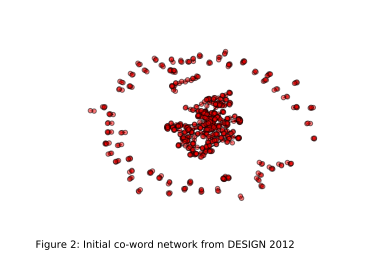

In [29]:
print('Number of Connected Components:', nx.number_connected_components(g))
pos = nx.spring_layout(g)
nx.draw_networkx(g, 
                 node_size=20,
                 alpha=0.5,
                 with_labels=False,
                 pos=pos)

plt.axis('off')
plt.annotate('Figure 2: Initial co-word network from DESIGN 2012', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Network Pruning

In order to remove these external components and nodes that are really used, a step known as 'pruning' occurs. This is where nodes are removed based on their characteristics within the network. This could be the frequency of their appearence and/or number of connections they have with the rest of the network for example. In this example, a node frequency of one has been used as the criteria for removing the node from the network. The removal also removes the edges associated with that node.

In [30]:
print('- Before Pruning -')
print('Number of Nodes in Network:', g.number_of_nodes())
print('Number of Edges in Network:', g.number_of_edges())

pruned_g = g.copy()
for n, d in g.nodes(data=True):
    if d['freq'] == 1:
        pruned_g.remove_node(n)
        
print('- After Pruning -')
print('Number of Nodes in Network:', pruned_g.number_of_nodes())
print('Number of Edges in Network:', pruned_g.number_of_edges())

- Before Pruning -
Number of Nodes in Network: 673
Number of Edges in Network: 1399
- After Pruning -
Number of Nodes in Network: 95
Number of Edges in Network: 134


## Graph Drawing

Figure 3 below shows the resulting network after the low frequency nodes have been removed. It can be seen that a large number of the components have removed although a few do remain. This may highlight some specialist or emerging themes of work, which has yet to find its place within the core research themes of the conference.

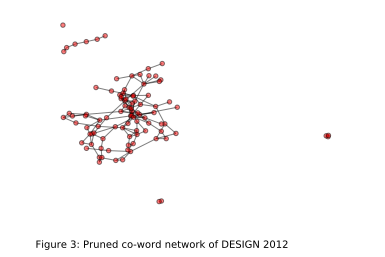

In [31]:
nx.draw_networkx(pruned_g, 
                 node_size=20,
                 alpha=0.5,
                 with_labels=False,
                 pos=pos)

plt.axis('off')
plt.annotate('Figure 3: Pruned co-word network of DESIGN 2012', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Applying Louvain Community Detection

Now that we have the pruned network that only contains the keywords that have been used by the majority of the conference papers, we can start to investigate the underlying structure of the network. One method of doing this is through clustering. In this example, we have applied the [Louvain Community detection algorithm](http://perso.crans.org/aynaud/communities/) to identify highly linked keywords ([Blondel et al., 2008](http://arxiv.org/pdf/0803.0476.pdf); [Wiki](https://en.wikipedia.org/wiki/Louvain_Modularity)).

The Louvain community algorithms' objective is to generate a set of clusters for the matrix that returns the highest modularity value. Modularity ($Q$) is an assessment of the quality of the matrix partition and is defined as [Newman (2004)](http://arxiv.org/pdf/cond-mat/0407503v1.pdf):


$$ Q = \frac{1}{2m}\sum_{ij}\bigg[A_{ij}-\frac{k_ik_j}{2m}\bigg]\delta(c_i,c_j) $$

Where $ m = \frac{1}{2}\sum_{ij}A_{ij} $ and is the number of co-occurrences within the matrix. $\delta$ is the Kronecker delta function and is 1 if a co-occurrence exists between two models and 0 otherwise. $ \frac{k_ik_j}{2m} $ is the probability that a co-occurrence may exist between two models, where $ k_i $ is the number of models that have co-occurrences with model $i$ and $ k_j $ is the number of models that have co-occurrences with model $j$. And, $A_{ij}$ is the weighted co-occurrence between two models in the matrix.

In order to obtain the highest modularity clustering, the algorithm iterates between two steps. The first assigns each model to its own cluster. This is then followed by the algorithm sequentially moving one model to a different cluster and calculating the change in modularity. From this, the maximum modularity change can be identified.

The second step merges the models together to form a cluster of models and combines the co-occurrences of model activity to form single co-occurrence links to the rest of the matrix and self-loops are used to identify internal co-occurrences between the models within the partition. The aim is to achieve a partitioning whereby each partition is highly connected internally and weakly connected to one another.

In this example, 12 clusters have been identified by the algorithm and the network drawn in Figure 4 has the nodes colour coded relation to these clusters.

Number of Clusters: 12


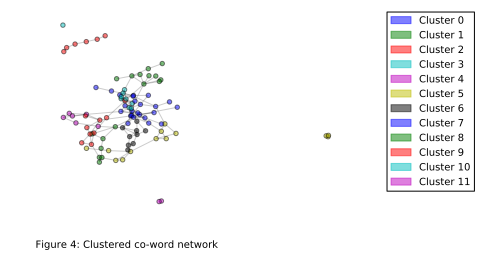

In [37]:
# run the louvain community detection algorithm (returns a dictionary odered by cluster number)
partition = community.best_partition(pruned_g)

# generate a set of colors for matplotlib
colors = "bgrcmykbgrcmykbgrcmykbgrcmyk"

number_of_partitions = 0
for idx in partition: # iterate throught the dictionary
    if partition[idx] > number_of_partitions:
        # if a new cluster then increment the cluster
        number_of_partitions = partition[idx]
            
    # draw the node and associated color
    nx.draw_networkx_nodes(pruned_g, 
                           nodelist=[idx], 
                           node_color=colors[partition[idx]],
                           node_size=20,
                           alpha=0.5,
                           pos=pos
                          )
    
# draw the edges
nx.draw_networkx_edges(pruned_g,
                       alpha=0.2,
                       pos=pos
                      )

print('Number of Clusters:', number_of_partitions)
legend_patches = []
for i in range(0, number_of_partitions):
    legend_patches.append( mpatches.Patch(color=colors[i], alpha=0.5, label='Cluster '+str(i)) )

plt.legend(handles=legend_patches, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.annotate('Figure 4: Clustered co-word network', (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
plt.axis('off')
plt.show()

## List nodes in a Cluster

Once we have the clusters, we can go one further and pull out the keywords that form the clusters. The code below shows and example of the keywords within cluster 10.

In [33]:
cluster_number = 10

keywords = []
print('Cluster:', cluster_number)
for idx in partition:
    if partition[idx] == cluster_number:
        print(g.node[idx]['keyword'])

Cluster: 10
system architecture


## Using Betweeness Centrality to Idenitfy Key Terms

In addition to clustering, we can analyse the nodes on the basis of how important they are in defining the structure of the network and the level of connectedness. This is often achieved through centrality measures and there are a number of different centrality measures that one can use. In this example, we are using the [Betweenness Centrality][1] measure, which counts the number of times a node is on the shortest paths between nodes in the network. This is defined mathematically as:

$$ c_B(v) = \sum_{s \neq v \neq t \in V}\frac{\sigma_{(s,t)}(v)}{\sigma_{(s,t)}} $$

where $\sigma_{(s,t)}$ is the total number of shortest paths from node $s$ to $t$ and $\sigma_{(s,t)}(v)$ is the number of paths through $v$.

For the DESIGN 2012 conference, it can be seen the Design Process, Product Development and Knowledge Management were the most central keywords within the conference. 

[1]: (https://en.wikipedia.org/wiki/Centrality)
[2]: (https://networkx.github.io/documentation/development/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)



In [34]:
centralities = nx.betweenness_centrality(g)

sorted_centralities = sorted(centralities.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_centralities[0:5])

print(g.node[sorted_centralities[0][0]])
print(g.node[sorted_centralities[1][0]])
print(g.node[sorted_centralities[2][0]])


[(0, 0.16745270950248872), (3, 0.09163613594966051), (1, 0.0806147991249519), (2, 0.0773491847927658), (12, 0.07281701533185184)]
{'keyword': 'design process', 'freq': 10}
{'keyword': 'product development', 'freq': 7}
{'keyword': 'knowledge management', 'freq': 7}


## References & Additional Reading

I hope that this brief introduction to co-word analysis has helped and inspired you to try it out on your datasets.

[Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, and Etienne Lefebvre. Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008(10):P10008, 2008.](http://arxiv.org/pdf/0803.0476.pdf)

[Mark EJ Newman. Analysis of weighted networks. Physical Review E, 70(5):056131, 2004.](http://arxiv.org/pdf/cond-mat/0407503v1.pdf)

[M. E. J. Newman. Modularity and community structure in networks. Proceedings of the National Academy of Sciences, 103(23):8577{8582, 2006. doi: 10.1073/pnas.0601602103.](http://www.pnas.org/content/103/23/8577.full.pdf)

[Wikipedia - Centrality](https://en.wikipedia.org/wiki/Centrality)

[Wikipedia - Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity)

[Wikipedia - Modularity (Networks)](https://en.wikipedia.org/wiki/Modularity_(networks))

In [1]:
# Setting the css styling of the notebook
from IPython.core.display import HTML

def load_css():
    style = open("../extras/custom.css", "r").read()
    return HTML("<style>"+style+"</style>")

load_css()